# Daily predictions ensemble

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import ExponentialSmoothing, RNNModel
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import os

from lib.constants import *
import lib.preprocessing.wavelets as wavelets
import lib.preprocessing.df_utils as df_utils
import lib.visualization.plot as plot
from lib.preprocessing.normalization import Normalizer, Scalers

mpl.rcParams.update(mpl.rcParamsDefault)


/home/piotrek/miniconda3/envs/mgr1/lib/python3.11/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


## Preprocessing

### Read and prepare dataframe

In [2]:
prices_daily = pd.read_parquet('lib/data/apple_daily.parquet')
prices_daily = df_utils.localize_dataframe_index(prices_daily)
prices_daily.head()

,close,high,low,open,volume,divCash
date,,,,,,
2010-01-04,6.431808,6.446534,6.382820,6.414376,493730093,0.0
2010-01-05,6.442927,6.479292,6.408967,6.449539,601905401,0.0
2010-01-06,6.340444,6.468473,6.333832,6.442927,552160552,0.0
2010-01-07,6.328723,6.371399,6.282741,6.363886,477131677,0.0
2010-01-08,6.370798,6.371399,6.283041,6.320308,447611247,0.0


In [3]:
ts_daily = df_utils.get_df_with_columns(prices_daily, ['close'])
ts_daily.head()

,close
date,
2010-01-04,6.431808
2010-01-05,6.442927
2010-01-06,6.340444
2010-01-07,6.328723
2010-01-08,6.370798


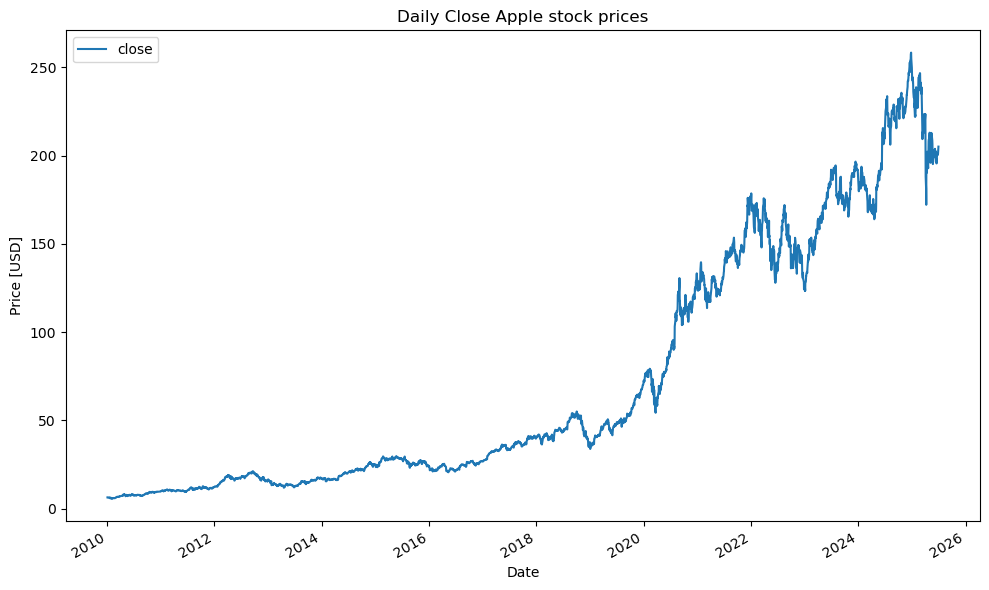

In [4]:
plot.plot_dataframe(ts_daily, title='Daily Close Apple stock prices', ylabel='Price [USD]', xlabel='Date')

In [5]:
ts_daily = ts_daily.asfreq('B', method='pad')
ts_daily

,close
date,
2010-01-04,6.431808
2010-01-05,6.442927
2010-01-06,6.340444
2010-01-07,6.328723
2010-01-08,6.370798
...,...
2025-06-24,200.300000
2025-06-25,201.560000
2025-06-26,201.000000


### Wavelet Transform

In [6]:
ts_daily['denoised'] = wavelets.wavelet_denoise_series(ts_daily["close"], wavelet='coif3', level=1)
ts_daily['noise'] = ts_daily["close"] - ts_daily['denoised']

Signal-to-Noise Ratio (SNR): 42.84 dB


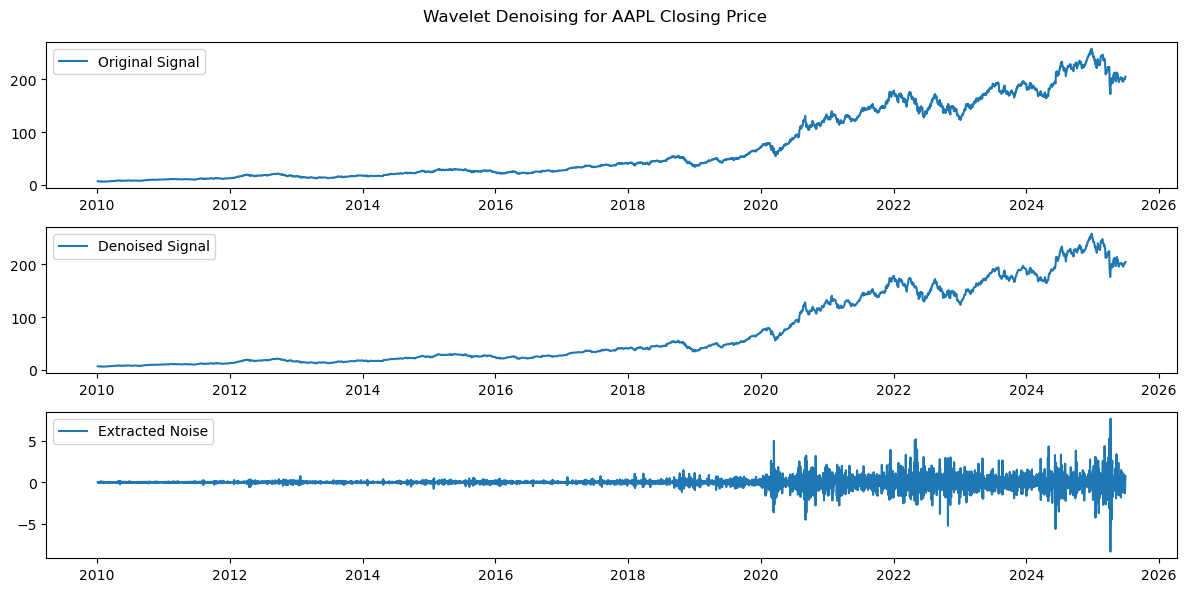

In [7]:
wavelets.plot_wavelet_denoising(ts_daily, f"{TICKER_APPLE} Closing Price")

### Create darts TimeSeries

<Axes: xlabel='date'>

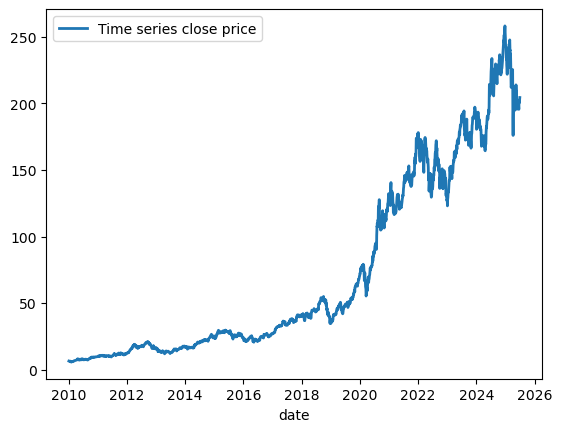

In [8]:
series = TimeSeries.from_dataframe(ts_daily, value_cols=["denoised"])
series.plot(label='Time series close price')

### Normalization

<Axes: xlabel='date'>

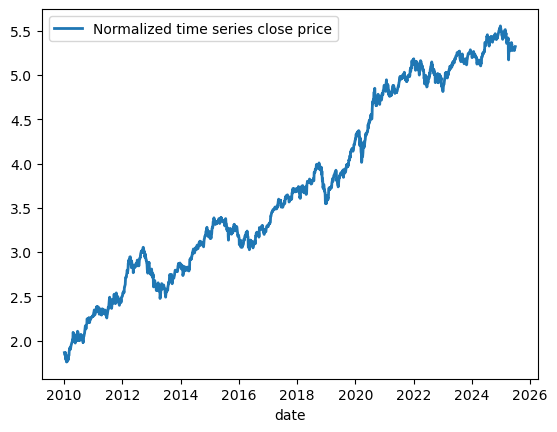

In [9]:
normalizer = Normalizer(diff=False)
normalized_series = normalizer.log_normalize(series)
# normalized_series = series
normalized_series.plot(label='Normalized time series close price')

## Prediction

### Arima

In [29]:
test_size = 160
val_size = 500
train_size = len(normalized_series) - val_size - test_size

train, val, test = (
    normalized_series[:train_size],
    normalized_series[train_size:train_size + val_size],
    normalized_series[-test_size:],
)

print(f"Train size: {len(train)}, Val size: {len(val)}, Test size: {len(test)}")

scaler = Scalers()
train_scaled = scaler.fit_scaler(train)
val_scaled = scaler.transform(val)
test_scaled = scaler.transform(test)

Train size: 3381, Val size: 500, Test size: 160


In [41]:
from darts.models import AutoARIMA

model_arima = AutoARIMA()
model_arima.fit(train_scaled.append(val_scaled))

AutoARIMA(add_encoders=None, quantiles=None, random_state=None)

In [42]:
from statsforecast.arima import ARIMASummary
print(ARIMASummary(model_arima.model.model_).summary())

ARIMA(5,1,2) with drift        

Coefficients:
               ar1    ar2    ar3    ar4    ar5    ma1    ma2  drift
coefficient  0.367 -0.565  0.333 -0.208  0.094  1.729  0.832  0.001
s.e.         0.025  0.020  0.020  0.017  0.016  0.016  0.016  0.016

sigma^2 = 0.0: log likelihood = 14950.86

AIC=-29883.72
None


In [84]:
arima_forecast = model_arima.historical_forecasts(
    test_scaled, 
    forecast_horizon=1,
    retrain=False,
    last_points_only=True,
    verbose=True,
    start=120,
)

historical forecasts:   0%|          | 0/40 [00:00<?, ?it/s]

In [85]:
arima_forecast_unscaled = scaler.inverse_scaler(arima_forecast)
arima_forecast_inversed = normalizer.inverse_log_normalize(
        arima_forecast_unscaled
    )

In [86]:
arima_f = arima_forecast_inversed.to_dataframe()
arima_f.columns = ["close"]

In [87]:
t = ts_daily[["denoised"]][-40:]

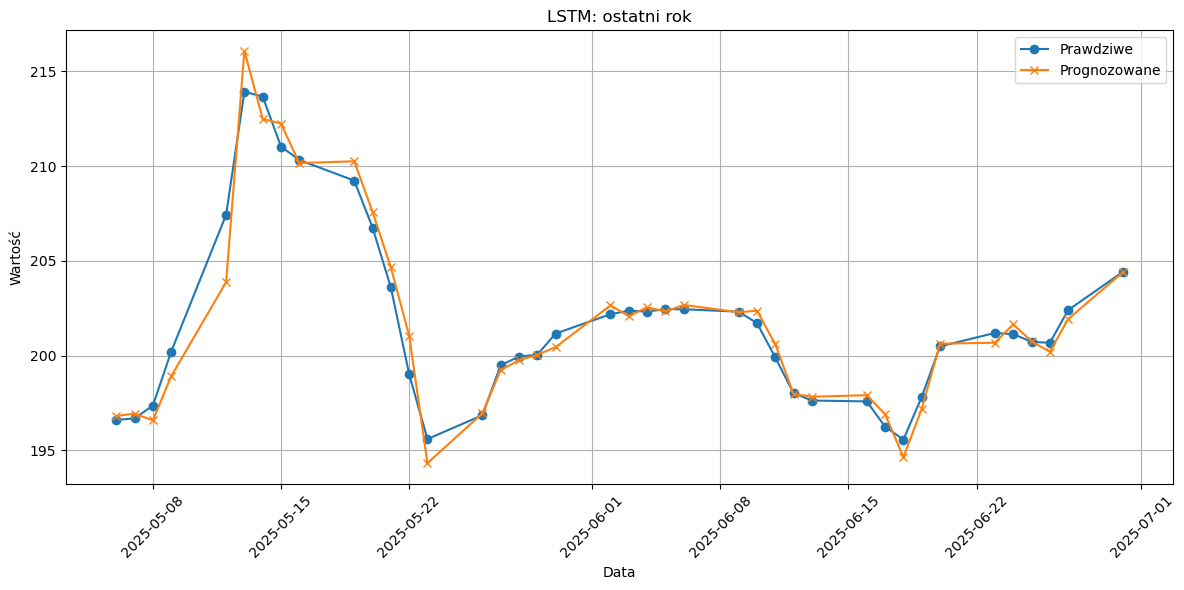

In [88]:
plt.figure(figsize=(12, 6))
plt.plot(t["denoised"], label="Prawdziwe", marker='o')
plt.plot(arima_f["close"], label="Prognozowane", marker='x')
plt.title("LSTM: ostatni rok")
plt.xlabel("Data")
plt.ylabel("Wartość")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### LSTM

In [ ]:
# test_size = 160
# val_size = 500
# train_size = len(normalized_series) - val_size - test_size

# train, val, test = (
#     normalized_series[:train_size],
#     normalized_series[train_size:train_size + val_size],
#     normalized_series[-test_size:],
# )

# print(f"Train size: {len(train)}, Val size: {len(val)}, Test size: {len(test)}")

# scaler = Scalers()
# train_scaled = scaler.fit_scaler(train)
# val_scaled = scaler.transform(val)
# test_scaled = scaler.transform(test)

Train size: 3381, Val size: 500, Test size: 160


In [ ]:
early_stopper = EarlyStopping(
    monitor="val_loss",
    patience=10,
    min_delta=1e-4,
    mode="min",
)

model_lstm = RNNModel(
    model="LSTM",
    input_chunk_length=120,
    training_length=121,
    hidden_dim=64,
    n_rnn_layers=2,
    batch_size=32,
    n_epochs=50,
    dropout=0.1,
    optimizer_kwargs={"lr": 1e-3},
    random_state=42,
    pl_trainer_kwargs={
        "accelerator": "gpu",
        "devices": 1,
        "callbacks": [early_stopper]
    },
    add_encoders={
        # a) atrybuty daty (one-hot kiedy ma sens)
        "datetime_attribute": {
            "past": ["dayofweek"],      # pon..niedz. (one-hot)
        },
        # b) cykliczne enkodowanie (sin/cos) — tu np. dzień roku
        "cyclic": {
            "past": ["dayofyear"],      # -> automatycznie zrobi sin/cos
        },
        # możesz dodać też np. 'month' itd.
    }
)

### BEST MODEL CONFIG

In [ ]:
# early_stopper = EarlyStopping(
#     monitor="val_loss",
#     patience=40,
#     min_delta=1e-5,
#     mode="min",
# )

# model_lstm = RNNModel(
#     model="LSTM",
#     input_chunk_length=120,
#     training_length=121,
#     hidden_dim=128,
#     n_rnn_layers=2,
#     batch_size=32,
#     n_epochs=400,
#     dropout=0.1,
#     optimizer_kwargs={"lr": 1e-4},
#     random_state=42,
#     pl_trainer_kwargs={
#         "accelerator": "gpu",
#         "devices": 1,
#         "callbacks": [early_stopper]
#     },
#     add_encoders={
#         # a) atrybuty daty (one-hot kiedy ma sens)
#         "datetime_attribute": {
#             "past": ["dayofweek"],      # pon..niedz. (one-hot)
#         },
#         # b) cykliczne enkodowanie (sin/cos) — tu np. dzień roku
#         "cyclic": {
#             "past": ["dayofyear"],      # -> automatycznie zrobi sin/cos
#         },
#         # możesz dodać też np. 'month' itd.
#     }
# )

In [23]:
model_lstm = RNNModel.load("lstm_model.pth.tar")

/home/piotrek/miniconda3/envs/mgr1/lib/python3.11/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.2, which is newer than your current Lightning version: v2.5.1.post0


In [ ]:
# model_lstm.fit(
#     train_scaled,
#     val_series=val_scaled,
#     verbose=True,
# )

In [ ]:
# from darts.metrics import mae

# parameters = {
#     'input_chunk_length':[100], 
#     'training_length':[101],
#     'model':['LSTM'], 
#     'n_epochs':[50],#, 300],
#     'hidden_dim':[64, 128],#, 100, 250], 
#     'n_rnn_layers':[2, 3], 
#     'dropout':[0.1, 0.2, 0.25],
#     'batch_size':[64],
#     'optimizer_kwargs':[{"lr": 1e-3}, {"lr": 1e-4}],
#     'pl_trainer_kwargs':[{
#         "accelerator": "gpu",
#         "devices": 1,
#         # "callbacks": [early_stopper]
#     }],
#     "add_encoders": [{
#         # a) atrybuty daty (one-hot kiedy ma sens)
#         "datetime_attribute": {
#             "past": ["dayofweek"],      # pon..niedz. (one-hot)
#             "future": ["dayofweek"],    # pon..niedz. (one-hot)
#         },
#         # b) cykliczne enkodowanie (sin/cos) — tu np. dzień roku
#         "cyclic": {
#             "past": ["dayofyear"],      # -> automatycznie zrobi sin/cos
#             "future": ["dayofyear"],    # -> automatycznie zrobi sin/cos
#         },
#         # możesz dodać też np. 'month' itd.
#     }]
# }

# output = RNNModel.gridsearch(
#     parameters=parameters,
#     series= train_scaled,
#     val_series=val_scaled,
#     metric=mae,
#     reduction=np.mean,
#     last_points_only=False,
#     verbose=True,
#     n_jobs=-1,
# )

gridsearch:   0%|          | 0/72 [00:00<?, ?it/s]

In [77]:
lstm_forecast = model_lstm.historical_forecasts(
    test_scaled,
    forecast_horizon=1,
    retrain=False,
    last_points_only=True,
    verbose=True,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/piotrek/miniconda3/envs/mgr1/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [95]:
lstm_forecast_unscaled = scaler.inverse_scaler(lstm_forecast)
lstm_forecast_inversed = normalizer.inverse_log_normalize(
        lstm_forecast_unscaled
    )

In [96]:
f_lstm = lstm_forecast_inversed.to_dataframe()
f_lstm.columns = ["close"]
# f.index = index[-40:]

In [97]:
t = ts_daily[["denoised"]][-40:]

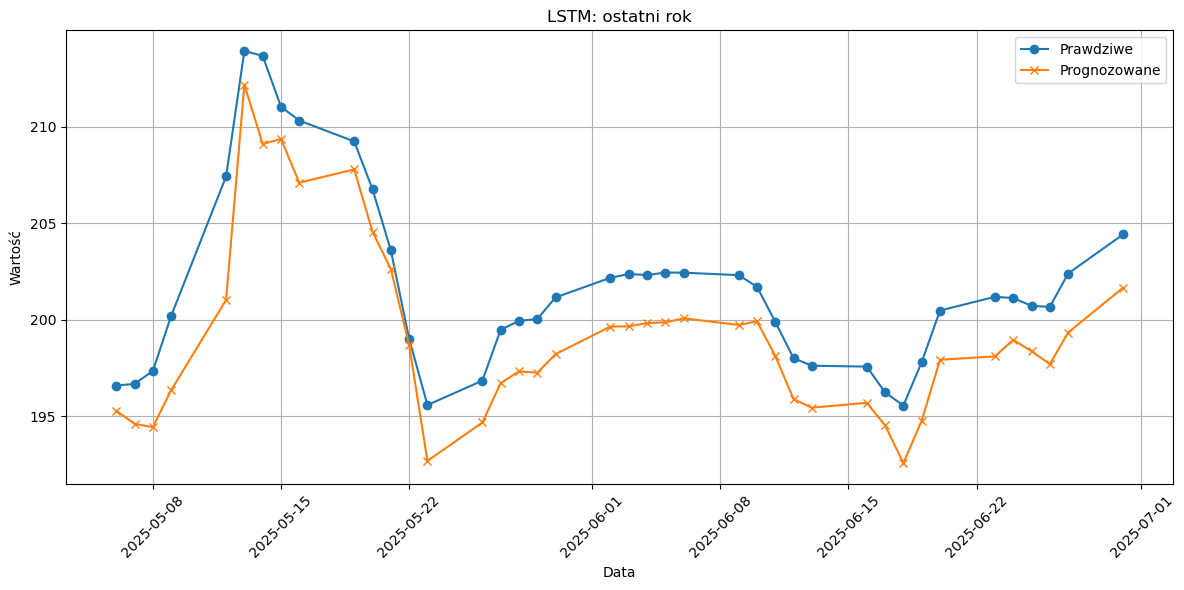

In [98]:
plt.figure(figsize=(12, 6))
plt.plot(t["denoised"], label="Prawdziwe", marker='o')
plt.plot(f_lstm["close"], label="Prognozowane", marker='x')
plt.title("LSTM: ostatni rok")
plt.xlabel("Data")
plt.ylabel("Wartość")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### Ensamble

In [99]:
arima_ensamble_train = model_arima.historical_forecasts(
    series=train_scaled.append(val_scaled),
    start=-200,
    forecast_horizon=1,
    stride=1,
    retrain=False,
    last_points_only=True,
    verbose=False,
)

lstm_ensamble_train = model_lstm.historical_forecasts(
    series=train_scaled.append(val_scaled),
    start=-200,
    forecast_horizon=1,
    stride=1,
    retrain=False,
    last_points_only=True,
    verbose=False,
)

# rzeczywiste wartości dla tych samych znaczników czasu
lstm_ensamble_train = lstm_ensamble_train.slice_intersect(arima_ensamble_train)
X = arima_ensamble_train.stack(lstm_ensamble_train)
y = val_scaled.slice_intersect(lstm_ensamble_train)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/piotrek/miniconda3/envs/mgr1/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


<Axes: xlabel='time'>

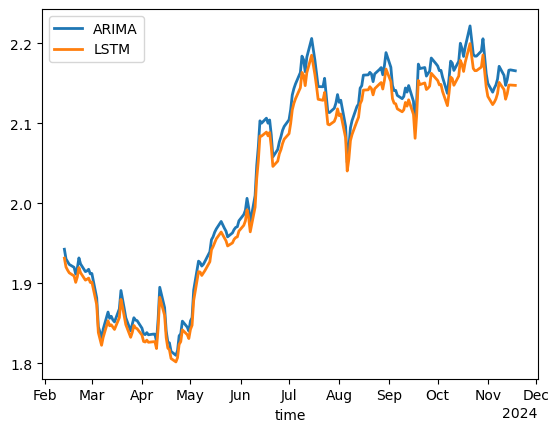

In [100]:
arima_ensamble_train.plot(label='ARIMA')
lstm_ensamble_train.plot(label='LSTM')

In [101]:
from darts.models import LinearRegressionModel

# prognozy bazowych modeli jako cechy regresji
reg_model = LinearRegressionModel(lags=None, lags_future_covariates=[0])

# dopasowujemy regresję na podstawie preds jako past_covariates
reg_model.fit(
    series=y,                # target
    future_covariates=X         # cechy = predykcje modeli bazowych
)

# prognoza na przyszłość:
# p1 = model_arima.predict(1, series=train_scaled.append(val_scaled))
# p2 = model_lstm.predict(1, series=train_scaled.append(val_scaled))
# future_preds = p1.stack(p2)

# y_pred = reg_model.predict(n=1, future_covariates=future_preds)

LinearRegressionModel(lags=None, lags_past_covariates=None, lags_future_covariates=[0], output_chunk_length=1, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

In [102]:
ensamble_test = arima_forecast.stack(lstm_forecast)
ensamble_forecast = reg_model.historical_forecasts(
    series=test_scaled.slice_intersect(ensamble_test), 
    future_covariates=ensamble_test, 
    forecast_horizon=1, 
    retrain=False, 
    last_points_only=True, 
    verbose=True,
)


historical forecasts:   0%|          | 0/1 [00:00<?, ?it/s]

In [107]:
ensamble_forecast_unscaled = scaler.inverse_scaler(ensamble_forecast)
ensamble_forecast_inversed = normalizer.inverse_log_normalize(
        ensamble_forecast_unscaled
    )

In [108]:
f_ensamble = ensamble_forecast_inversed.to_dataframe()
f_ensamble.columns = ["close"]

In [109]:
t = ts_daily[["denoised"]][-40:]

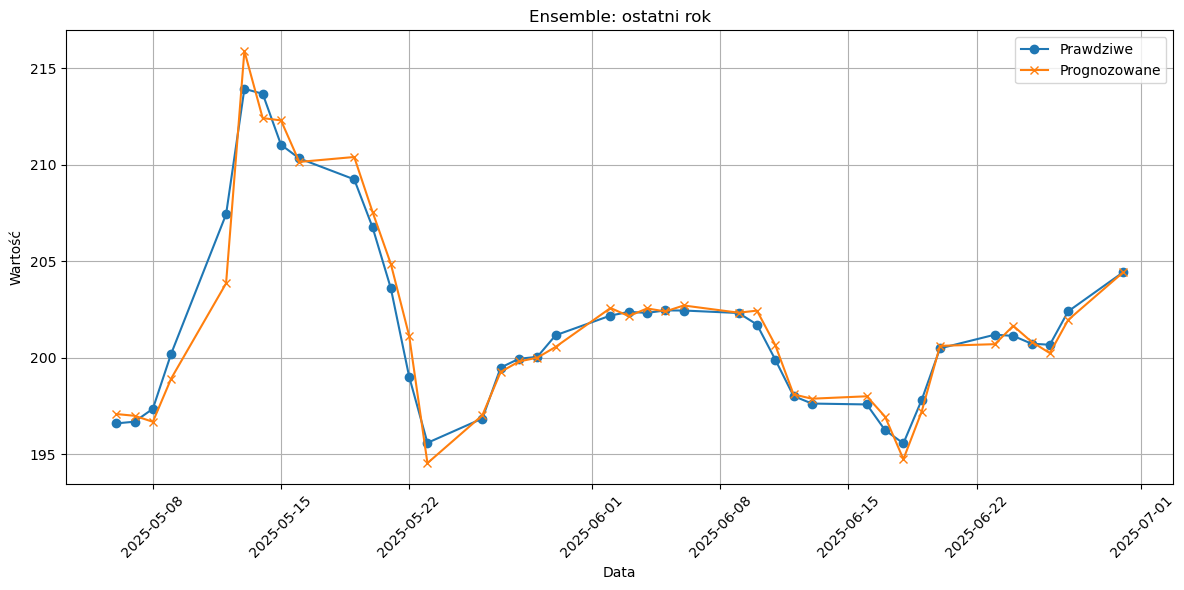

In [110]:
plt.figure(figsize=(12, 6))
plt.plot(t["denoised"], label="Prawdziwe", marker='o')
plt.plot(f_ensamble["close"], label="Prognozowane", marker='x')
plt.title("Ensemble: ostatni rok")
plt.xlabel("Data")
plt.ylabel("Wartość")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [111]:
print("Intercept:", reg_model.model.intercept_)
print("Coefficients:", reg_model.model.coef_)

Intercept: -0.007826347261229216
Coefficients: [0.73888499 0.26690216]


### Metrics

Directional Movement Metrics
Directional Accuracy: 0.7500
Precision (Rise): 0.7143
Precision (Fall): 0.7895
Recall: 0.7895
F1 Score: 0.7500


Text(0.5, 1.0, 'Macierz pomyłek kierunku ruchu (Ensamble)')

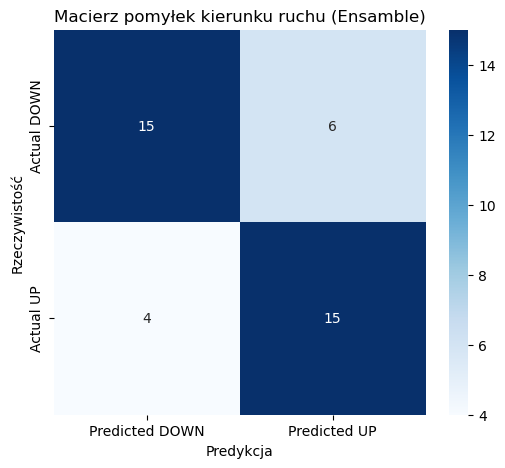

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

# 1. Kierunkowe etykiety: 1 = wzrost, 0 = spadek lub brak zmiany
def direction_labels(values):
    return np.where(np.diff(values, prepend=values[0]) >= 0, 1, 0)

true_dir = direction_labels(t["denoised"].values)
pred_dir = direction_labels(f_ensamble["close"].values)

# 2. Oblicz metryki
accuracy = accuracy_score(true_dir, pred_dir)
precision_rise = precision_score(true_dir, pred_dir, pos_label=1)
precision_fall = precision_score(true_dir, pred_dir, pos_label=0)
recall = recall_score(true_dir, pred_dir)
f1 = f1_score(true_dir, pred_dir)

# 3. Macierz pomyłek
cm = confusion_matrix(true_dir, pred_dir)
cm_df = pd.DataFrame(cm, index=["Actual DOWN", "Actual UP"], columns=["Predicted DOWN", "Predicted UP"])

# 4. Wyniki
metrics = {
    "Directional Accuracy": accuracy,
    "Precision (Rise)": precision_rise,
    "Precision (Fall)": precision_fall,
    "Recall": recall,
    "F1 Score": f1
}
metrics_df = pd.DataFrame(metrics, index=["Score"])

print("Directional Movement Metrics")
for metric, score in metrics.items():
    print(f"{metric}: {score:.4f}")

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap="Blues", linewidths=0)
plt.grid(False)
plt.tight_layout

plt.xlabel("Predykcja")
plt.ylabel("Rzeczywistość")
plt.title("Macierz pomyłek kierunku ruchu (Ensamble)")

In [114]:
from darts.metrics import mape, mae

mape_value = mape(test, ensamble_forecast_unscaled, intersect=True)
mae_value = mae(test, ensamble_forecast_unscaled, intersect=True)

print(f"MAE:  {mae_value:.4f}")
print(f"MAPE: {mape_value:.2f}%")

MAE:  0.0032
MAPE: 0.06%
